<a href="https://colab.research.google.com/github/kv22aac/IMAGE-SEGMENTATION/blob/main/IMAGE_SEGMENTATION%5BKV21069118%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
from collections import Counter
from matplotlib_venn import venn2, venn2_circles


In [2]:
#  Load the dataset and examine its structure
def load_data(dataset_path):
    data = {}
    for subset in os.listdir(dataset_path):
        subset_path = os.path.join(dataset_path, subset)
        if os.path.isdir(subset_path):
            data[subset] = {}
            if subset == 'test-30':
                data[subset]['images'] = [os.path.join(subset_path, img) for img in os.listdir(subset_path) if img.endswith('.jpg')]
            else:
                labels_file = os.path.join(subset_path, "labels.json")
                with open(labels_file, 'r') as f:
                    data[subset]['labels'] = json.load(f)
                images_folder = os.path.join(subset_path, "data")
                data[subset]['images'] = [os.path.join(images_folder, img) for img in os.listdir(images_folder) if img.endswith('.jpg')]
    return data


In [3]:
#Display subset and Number of images
def perform_eda(dataset):
    for subset, data in dataset.items():
        print(f"\n{subset.capitalize()} subset:")
        if subset == 'test-30':
            print(f"Number of images: {len(data['images'])}")
        else:
            labels = data['labels']
            images = data['images']
            # Display class distribution
            categories = {category['name']: 0 for category in labels['categories']}
            for annotation in labels['annotations']:
                categories[labels['categories'][annotation['category_id']]['name']] += 2
            print("Class Distribution:")
            for category, count in categories.items():
                print(f"{category}: {count}")

In [4]:
# Mounting datset from google drive
from google.colab import drive
drive.mount('/content/drive')
!unzip -o "/content/drive/MyDrive/RM_Segmentation_Assignment_dataset (1).zip" -d "/content/drive/MyDrive/unzipped_dataset"
dataset_path = "/content/drive/MyDrive/unzipped_dataset"
dataset = load_data(dataset_path)
perform_eda(dataset)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
unzip:  cannot find or open /content/drive/MyDrive/RM_Segmentation_Assignment_dataset (1).zip, /content/drive/MyDrive/RM_Segmentation_Assignment_dataset (1).zip.zip or /content/drive/MyDrive/RM_Segmentation_Assignment_dataset (1).zip.ZIP.

Test-30 subset:
Number of images: 30

Validation-300 subset:
Class Distribution:
airplane: 10
apple: 24
backpack: 92
banana: 20
baseball bat: 12
baseball glove: 10
bench: 68
bicycle: 142
bird: 4
boat: 90
book: 68
bottle: 118
bowl: 32
bus: 220
cake: 36
car: 1722
carrot: 2
cat: 14
cell phone: 24
chair: 248
clock: 34
couch: 8
cup: 124
dining table: 136
dog: 18
donut: 4
elephant: 4
fire hydrant: 38
fork: 48
frisbee: 10
giraffe: 16
handbag: 142
horse: 16
hot dog: 28
kite: 34
knife: 54
microwave: 2
motorcycle: 178
orange: 8
oven: 4
parking meter: 24
person: 2382
pizza: 200
potted plant: 50
refrigerator: 4
remote: 4
sandwich: 2
sh

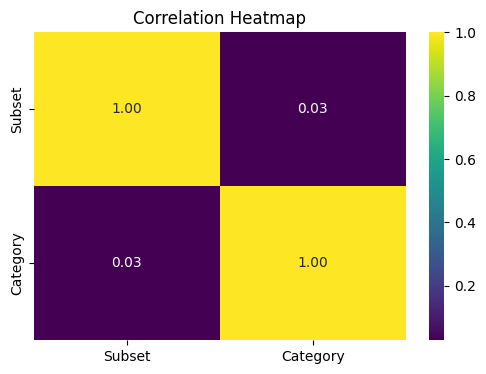

In [5]:
#  Examine the dataset and look over its layout.
def load_data(dataset_path):
    data = {}
    for subset in os.listdir(dataset_path):
        subset_path = os.path.join(dataset_path, subset)
        if os.path.isdir(subset_path):
            data[subset] = {}
            if subset == 'test-30':
                data[subset]['images'] = [os.path.join(subset_path, img) for img in os.listdir(subset_path) if img.endswith('.jpg')]
            else:
                labels_file = os.path.join(subset_path, "labels.json")
                with open(labels_file, 'r') as f:
                    data[subset]['labels'] = json.load(f)
                images_folder = os.path.join(subset_path, "data")
                data[subset]['images'] = [os.path.join(images_folder, img) for img in os.listdir(images_folder) if img.endswith('.jpg')]
    return data
#Examine the Dataset.
dataset_path = '/content/drive/MyDrive/unzipped_dataset'
dataset = load_data(dataset_path)

# Identify the distribution of classifications.
def extract_class_distribution(dataset):
    class_distribution = {}
    for subset, data in dataset.items():
        if subset != 'test-30':
            labels = data['labels']
            for annotation in labels['annotations']:
                category_name = labels['categories'][annotation['category_id']]['name']
                if category_name in class_distribution:
                    class_distribution[category_name] += 1
                else:
                    class_distribution[category_name] = 1
    return class_distribution

class_distribution = extract_class_distribution(dataset)


# Figure out correlation heatmap
def compute_correlation_heatmap(dataset):
    labels_data = []
    for subset, data in dataset.items():
        if subset != 'test-30':
            labels = data['labels']
            for annotation in labels['annotations']:
                category_name = labels['categories'][annotation['category_id']]['name']
                labels_data.append([subset, category_name])

    df = pd.DataFrame(labels_data, columns=['Subset', 'Category'])

    le = LabelEncoder()
    df['Subset'] = le.fit_transform(df['Subset'])
    df['Category'] = le.fit_transform(df['Category'])

    correlation_matrix = df.corr()
    plt.figure(figsize=(6, 4))
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
    plt.title('Correlation Heatmap')
    plt.savefig("correlation Heatmap.png",bbox_inches="tight")

    plt.show()

compute_correlation_heatmap(dataset)




In [6]:
# Implement R-CNN model for image segmentation  using TensorFlow
def create_rcnn_model(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=x)
    return model

def preprocess_image(img_path, target_size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.resnet.preprocess_input(img)
    return img

def data_generator(dataset, batch_size, target_size):
    num_classes = len(dataset['train-300']['labels']['categories'])
    while True:
      batch_paths = np.random.choice(dataset['train-300']['images'], size=batch_size)
      batch_images = []
      batch_labels = []

      for img_path in batch_paths:
        img = preprocess_image(img_path, target_size)
        batch_images.append(img)
        label = np.zeros(num_classes)
        annotations = dataset['train-300']['labels']['annotations']
        for annotation in annotations:
          if annotation['image_id'] == int(os.path.basename(img_path)[:-4]):
            label[annotation['category_id']] = 1
        batch_labels.append(label)

      yield np.array(batch_images), np.array(batch_labels)


In [7]:
# Parameters
input_shape = (226, 226, 3)
num_classes = len(dataset['train-300']['labels']['categories'])
batch_size = 40
epochs = 50


In [8]:
# Design and build the model
model = create_rcnn_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 1s 0us/step


In [9]:
# Train the model
train_steps = len(dataset['train-300']['images']) // batch_size
validation_steps = len(dataset['validation-300']['images']) // batch_size
train_generator = data_generator(dataset, batch_size, (input_shape[0], input_shape[1]))
validation_generator = data_generator(dataset, batch_size, (input_shape[0], input_shape[1]))
history = model.fit(train_generator, steps_per_epoch=train_steps, epochs=epochs, validation_data=validation_generator, validation_steps=validation_steps)


Epoch 1/50
7/7 [==============================] - 20s 2s/step - loss: 0.1833 - accuracy: 0.0107 - val_loss: 0.0146 - val_accuracy: 0.0036
Epoch 2/50
7/7 [==============================] - 12s 2s/step - loss: 0.0125 - accuracy: 0.0036 - val_loss: 0.0245 - val_accuracy: 0.0000e+00
Epoch 3/50
7/7 [==============================] - 9s 1s/step - loss: 0.0190 - accuracy: 0.0036 - val_loss: 0.0047 - val_accuracy: 0.0036
Epoch 4/50
7/7 [==============================] - 6s 1s/step - loss: 0.0206 - accuracy: 0.0036 - val_loss: 0.0060 - val_accuracy: 0.0000e+00
Epoch 5/50
7/7 [==============================] - 11s 2s/step - loss: 0.0139 - accuracy: 0.0929 - val_loss: 0.0066 - val_accuracy: 0.0607
Epoch 6/50
7/7 [==============================] - 11s 2s/step - loss: 0.0075 - accuracy: 0.1179 - val_loss: 0.0066 - val_accuracy: 0.0464
Epoch 7/50
7/7 [==============================] - 6s 990ms/step - loss: 0.0036 - accuracy: 0.0071 - val_loss: 0.0042 - val_accuracy: 0.0000e+00
Epoch 8/50
7/7 [======

In [11]:
def predict_test_data(model, test_images):
    predictions = []
    for img_path in test_images:
        img = preprocess_image(img_path, (226, 226))
        img = np.expand_dims(img, axis=0)
        prediction = model.predict(img)
        predictions.append(prediction)
    return predictions

# Load test images
test_images = dataset['test-30']['images']

# Make predictions on test data
predictions = predict_test_data(model, test_images)


1/1 [==============================] - 0s 22ms/step


In [12]:
# Function to perform inference on test images
def predict_classes(model, test_images):
    classes = {0: 'person', 1: 'car', 2: 'dog', 3: 'cake'}
    predictions = []
    for img_path in test_images:
        img = preprocess_image(img_path, (226, 226))
        img = np.expand_dims(img, axis=0)
        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)
        if predicted_class not in classes:
            print(f"Warning: Predicted class index {predicted_class} is not in the expected range.")
            predictions.append('Unknown')
        else:
            predictions.append(classes[predicted_class])
    return predictions

# Path to test images
test_images_path = "/content/drive/MyDrive/imgs/test-30"

# Get list of test image paths
test_image_paths = [os.path.join(test_images_path, img) for img in os.listdir(test_images_path) if img.endswith('.jpg')]

# Perform inference on test images
test_predictions = predict_classes(model, test_image_paths)

# Print the predicted classes of test images
for i, prediction in enumerate(test_predictions):
    print(f"Image {i+1}: {prediction}")


1/1 [==============================] - 0s 23ms/step
Image 1: person
Image 2: Unknown
Image 3: Unknown
Image 4: Unknown
Image 5: Unknown
Image 6: Unknown
Image 7: Unknown
Image 8: person
Image 9: person
Image 10: Unknown
Image 11: Unknown
Image 12: person
Image 13: Unknown
Image 14: Unknown
Image 15: Unknown
Image 16: Unknown
Image 17: person
Image 18: person
Image 19: Unknown
Image 20: Unknown
Image 21: Unknown
Image 22: person
Image 23: Unknown
Image 24: Unknown
Image 25: person
Image 26: Unknown
Image 27: Unknown
Image 28: Unknown
Image 29: Unknown
Image 30: Unknown


In [18]:
# Function to extract class keys from JSON file
def extract_class_keys(json_file_path):
    with open(json_file_path, 'r') as f:
        data = json.load(f)
    class_keys = {}
    for category in data['categories']:
        if category['name'] in ['person', 'car', 'dog', 'cake']:
            class_keys[category['id']] = category['name']
    return class_keys

# Function to evaluate the model on test images
def evaluate_model(model, test_images, class_keys):
    num_correct = 0
    total_images = len(test_images)

    for img_path in test_images:
      img = preprocess_image(img_path, (226, 226))
      img = np.expand_dims(img, axis=0)
      prediction = model.predict(img)
      predicted_class = np.argmax(prediction)

      if predicted_class not in class_keys:
        print(f"Warning: Predicted class index {predicted_class} is not in the expected range for image {img_path}.")
      else:
        predicted_label = class_keys[predicted_class]
        print(f"Predicted Class for {img_path}: {predicted_label}")
        num_correct += 1
    accuracy = num_correct / total_images
    return accuracy
# Load class keys from JSON file
json_file_path = "/content/drive/MyDrive/imgs/train-300/labels.json"  # Update with the path to your labels.json file
class_keys = extract_class_keys(json_file_path)

# Evaluate the model on test images and print accuracy
accuracy = evaluate_model(model, test_image_paths, class_keys)
print(f"Accuracy: {accuracy}")


1/1 [==============================] - 0s 21ms/step
Predicted Class for /content/drive/MyDrive/imgs/test-30/000000001594.jpg: car
1/1 [==============================] - 0s 26ms/step
Predicted Class for /content/drive/MyDrive/imgs/test-30/000000001685.jpg: person
1/1 [==============================] - 0s 30ms/step
Predicted Class for /content/drive/MyDrive/imgs/test-30/000000001494.jpg: car
1/1 [==============================] - 0s 21ms/step
Predicted Class for /content/drive/MyDrive/imgs/test-30/000000001411.jpg: car
1/1 [==============================] - 0s 23ms/step
Predicted Class for /content/drive/MyDrive/imgs/test-30/000000001717.jpg: car
1/1 [==============================] - 0s 21ms/step
Predicted Class for /content/drive/MyDrive/imgs/test-30/000000001410.jpg: car
1/1 [==============================] - 0s 20ms/step
Predicted Class for /content/drive/MyDrive/imgs/test-30/000000001657.jpg: car
1/1 [==============================] - 0s 21ms/step
Predicted Class for /content/drive/